In [460]:
import torch
from torch import nn
import numpy as np
import pandas
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (10,6)

pandas.set_option('precision', 20)

In [387]:
class Network(nn.Module):
        def __init__(self):
                super().__init__()

                # Layer sizes
                self.input = nn.Linear(6, 50)
                self.first_hidden = nn.Linear(50, 100)
                self.second_hidden = nn.Linear(100, 500)
                self.third_hidden = nn.Linear(500, 250)
                self.fourth_hidden = nn.Linear(250, 100)
                self.fifth_hidden = nn.Linear(100, 50)
                self.output = nn.Linear(50, 1)

                # Activation functions
                self.relu = nn.ReLU()
                self.sigmoid = nn.Sigmoid()

        def forward(self, x:[])->[]:
                x = self.input(x)
                x = self.relu(x)
                x = self.first_hidden(x)
                x = self.relu(x)
                x = self.second_hidden(x)
                x = self.relu(x)
                x = self.third_hidden(x)
                x = self.relu(x)
                x = self.fourth_hidden(x)
                x = self.relu(x)
                x = self.fifth_hidden(x)
                x = self.relu(x)            
                x = self.output(x)

                return x

In [659]:
def get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength, mode)->torch.tensor:
    wavelengths = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)
    
    fill_factor = (fill_factor - dataframe.min()['Fill Factor'])/\
    (dataframe.max()['Fill Factor'] - dataframe.min()['Fill Factor'])
    
    pitch = (pitch - dataframe.min()['Pitch'])/(dataframe.max()['Pitch'] - dataframe.min()['Pitch'])
    
    theta = (theta - dataframe.min()['Theta'])/(dataframe.max()['Theta'] - dataframe.min()['Theta'])
    
    duty_cycle = (duty_cycle - dataframe.min()['Duty Cycle'])/(dataframe.max()['Duty Cycle'] - dataframe.min()['Duty Cycle'])
    
    wavelength = (wavelength - min(wavelengths))/(max(wavelengths) - min(wavelengths))
    
    return torch.tensor([theta, pitch, duty_cycle, fill_factor, wavelength, mode], dtype=torch.float32)


def get_transmission_val(nn_val)->float:
    return np.power(10, nn_val.detach().numpy())


def get_features(dataframe:pandas.DataFrame)->torch.Tensor:
    return dataframe[["Theta", "Pitch", "Duty Cycle", "Fill Factor", "Lambda", "Mode"]].values


def get_labels(dataframe:pandas.DataFrame)->torch.Tensor:
    return dataframe[['Transmission']].values

In [656]:
class MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, actual):
        return self.mse(pred, actual)


class mean_absolute_error(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, actual):
        return torch.mean(torch.abs((pred - actual) / actual))

***Load in the Grating Coupler Model***

In [650]:
GratingCouplerNet = torch.load('DATA_FILES/GratingCouplerNetModel').eval()
GratingCouplerNet

Network(
  (input): Linear(in_features=6, out_features=100, bias=True)
  (first_hidden): Linear(in_features=100, out_features=250, bias=True)
  (second_hidden): Linear(in_features=250, out_features=500, bias=True)
  (third_hidden): Linear(in_features=500, out_features=250, bias=True)
  (fourth_hidden): Linear(in_features=250, out_features=100, bias=True)
  (fifth_hidden): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [674]:
GratingCouplerNet = torch.load('DATA_FILES/GratingCouplerNetModel_batch_1000-2').eval()
GratingCouplerNet

Network(
  (input): Linear(in_features=6, out_features=100, bias=True)
  (first_hidden): Linear(in_features=100, out_features=250, bias=True)
  (second_hidden): Linear(in_features=250, out_features=500, bias=True)
  (third_hidden): Linear(in_features=500, out_features=250, bias=True)
  (fourth_hidden): Linear(in_features=250, out_features=100, bias=True)
  (fifth_hidden): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [664]:
dataframe = pandas.read_csv('DATA_FILES/dataset_new.csv')
training_statistics = pandas.read_csv('DATA_FILES/training_stats_03March2022.csv')
training_statistics2 = pandas.read_csv('DATA_FILES/training_stats_16March2022.csv')
training_statistics3 = pandas.read_csv('DATA_FILES/training_stats_21March2020.csv')
dusan_paper_TM = pandas.read_csv('TEST_SIMULATIONS/Dusans_Plot_TM_mode.txt')
dusan_paper_TE = pandas.read_csv('TEST_SIMULATIONS/Dusans_Plot_TE_mode.txt')
test_TM = pandas.read_csv('TEST_SIMULATIONS/Testing_TM.txt')
test_TE = pandas.read_csv('TEST_SIMULATIONS/Testing_TE.txt')
test_TM2 = pandas.read_csv('TEST_SIMULATIONS/Testing_TM_2.txt')
test_TE2 = pandas.read_csv('TEST_SIMULATIONS/Testing_TE_2.txt')
test_TM3 = pandas.read_csv('TEST_SIMULATIONS/Testing_TM_3.txt')
test_TE3 = pandas.read_csv('TEST_SIMULATIONS/Testing_TE_3.txt')
test_TM5 = pandas.read_csv('TEST_SIMULATIONS/TM5.txt')
test_TE5 = pandas.read_csv('TEST_SIMULATIONS/TE5.txt')

In [679]:
dataframe = pandas.read_csv('DATA_FILES/dataset_killed_low_vals_min_max_normalized_20March2022.csv')
no_noise_training_set = pandas.read_csv("DATA_FILES/training_set_killed_low_vals_20March2022.csv")
no_noise_testing_set = pandas.read_csv("DATA_FILES/testing_set_killed_low_vals_20March2022.csv")

mse_error = MSELoss()
mae_error = mean_absolute_error()

In [682]:
x_vals = torch.tensor(get_features(no_noise_training_set), dtype=torch.float32)
y_vals = torch.tensor(np.abs(get_labels(no_noise_training_set)), dtype=torch.float32)

In [672]:
x_vals

array([[0.        , 0.1980198 , 1.        , 0.        , 0.6       ,
        1.        ],
       [0.8       , 0.1980198 , 0.8       , 0.6       , 0.65      ,
        1.        ],
       [0.6       , 0.59405941, 0.        , 1.        , 0.375     ,
        1.        ],
       ...,
       [0.2       , 0.59405941, 1.        , 0.4       , 0.85      ,
        0.        ],
       [0.2       , 0.3960396 , 0.6       , 0.        , 0.5       ,
        0.        ],
       [0.8       , 0.59405941, 0.8       , 0.4       , 0.75      ,
        0.        ]])

In [688]:
mae_error(torch.pow(10, GratingCouplerNet(x_vals)), y_vals)

tensor(0.5986, grad_fn=<MeanBackward0>)

In [665]:
dataframe

,Theta,Pitch,Duty Cycle,Fill Factor,Mode,Lambda,Transmission
0,5.0,0.00000050,0.40000000000000002220,0.20000000000000001110,0,0.00000170,0.00009679999999999999
1,5.0,0.00000050,0.40000000000000002220,0.20000000000000001110,0,0.00000170,0.00009790000000000001
2,5.0,0.00000050,0.40000000000000002220,0.20000000000000001110,0,0.00000169,0.00009970000000000000
3,5.0,0.00000050,0.40000000000000002220,0.20000000000000001110,0,0.00000169,0.00010178900000000000
4,5.0,0.00000050,0.40000000000000002220,0.20000000000000001110,0,0.00000169,0.00010362100000000000
...,...,...,...,...,...,...,...
602395,11.0,0.00000151,0.44444399999999995021,0.55555600000000004979,1,0.00000131,-0.00080868699999999999
602396,11.0,0.00000151,0.44444399999999995021,0.55555600000000004979,1,0.00000130,-0.00084836399999999989
602397,11.0,0.00000151,0.44444399999999995021,0.55555600000000004979,1,0.00000130,-0.00088449199999999996
602398,11.0,0.00000151,0.44444399999999995021,0.55555600000000004979,1,0.00000130,-0.00094034800000000003


***Looking at the learning and testing losses ...***

From the figure below we can see that the testing loss follows the learning loss ...


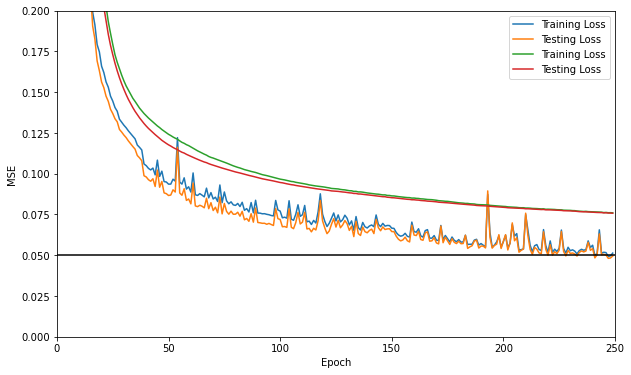

In [649]:
plt.plot(training_statistics['training_loss'], label='Training Loss')
plt.plot(training_statistics['testing_loss'], label='Testing Loss')
plt.plot(training_statistics3['training_loss'], label='Training Loss')
plt.plot(training_statistics3['testing_loss'], label='Testing Loss')
plt.axhline(y=0.05, color='k', linestyle='-')
# plt.plot(training_statistics2['training_loss'], label='Training Loss')
# plt.plot(training_statistics2['testing_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.axis([0, 250, 0, 0.2])
plt.legend()

Text(0, 0.5, 'Training Time (mins)')

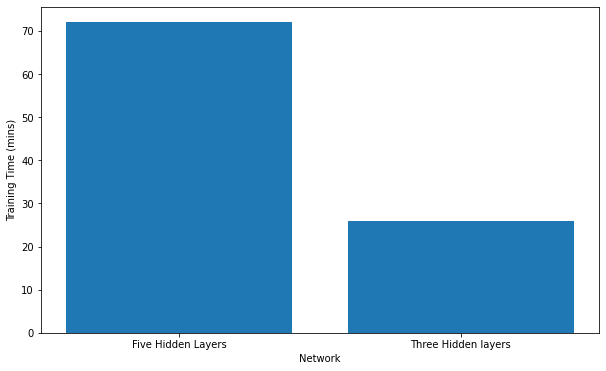

In [647]:
data = {'Five Hidden Layers': 72, 'Three Hidden layers': 25.91}
networks = list(data.keys())
training_minutes = list(data.values())
plt.bar(networks, training_minutes)
plt.xlabel('Network')
plt.ylabel('Training Time (mins)')

***Looking at the learning rate over the epochs ...***

For this training I chose to keep the learning rate constant over the training cycle

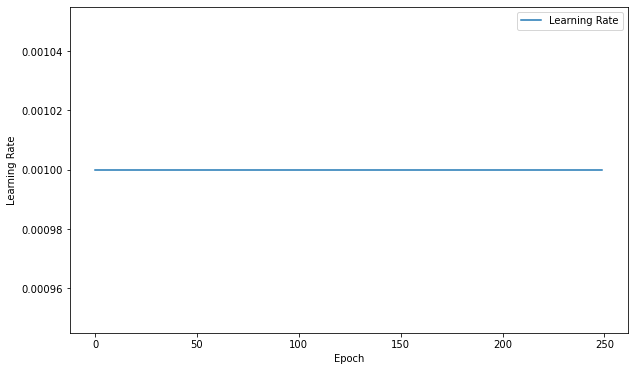

In [342]:
plt.plot(training_statistics['learning_rate'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

***COMPARING TO DUSAN'S PAPER***

In [623]:
# Validation at low vals
theta = (5)
pitch = (0.7*10**(-6))
duty_cycle = (0.48)
fill_factor = (0.2)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, GratingCouplerNet(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, GratingCouplerNet(x).detach().numpy())

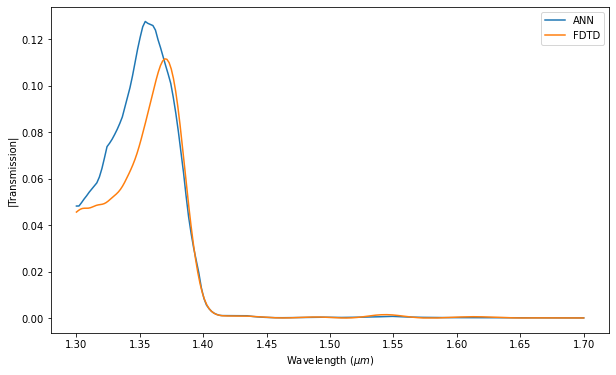

In [636]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(test_TE5['X'])/10**(-6), np.abs(np.flip(test_TE5['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

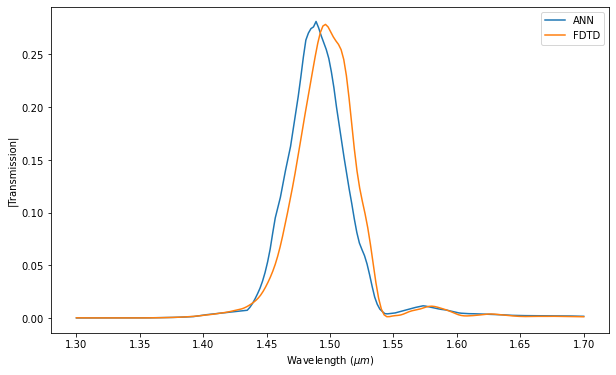

In [637]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.plot(np.flip(test_TM5['X'])/10**(-6), np.abs(np.flip(test_TM5['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

In [603]:
# Comparison to Dusan Paper
theta = (14.375)
pitch = (0.75*10**(-6))
duty_cycle = (0.65)
fill_factor = (0.25)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, GratingCouplerNet(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, GratingCouplerNet(x).detach().numpy())

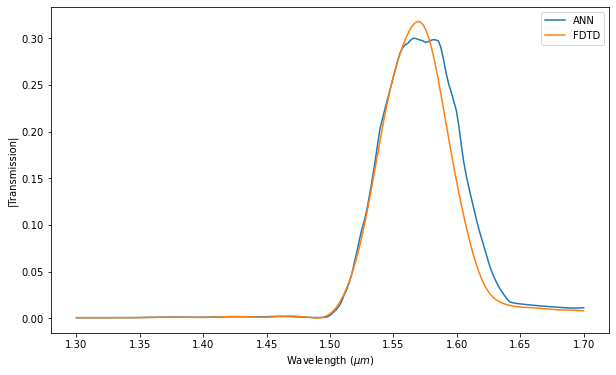

In [604]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.plot(np.flip(dusan_paper_TM['X'])/10**(-6), np.abs(np.flip(dusan_paper_TM['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

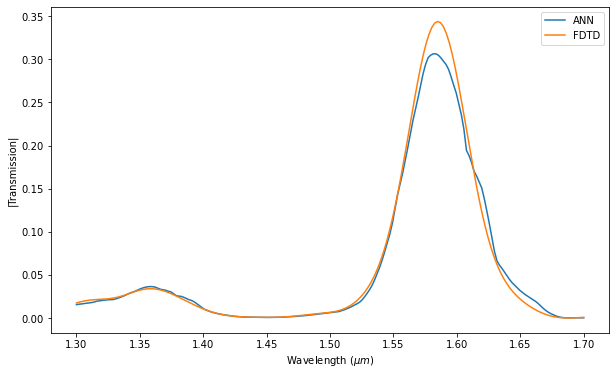

In [605]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(dusan_paper_TE['X'])/10**(-6), np.abs(np.flip(dusan_paper_TE['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

***TESTING OUT OPTIMIZING PARAMETERS AT $\lambda=1.55\ \mu m$***

In [607]:
thetas = np.linspace(dataframe.min()['Theta'], dataframe.max()['Theta'], 10)
pitchs = np.linspace(dataframe.min()['Pitch'], dataframe.max()['Pitch'], 10)
duty_cycles = np.linspace(dataframe.min()['Duty Cycle'], dataframe.max()['Duty Cycle'], 10)
fill_factors = np.linspace(dataframe.min()['Fill Factor'], dataframe.max()['Fill Factor'], 10)
mode = 0
wavelength = 1.55*10**(-6)

In [608]:
max_val = 0;
params = [0, 0, 0, 0]
mode = 0
count = 1

for theta in thetas:
    for pitch in pitchs:
        for duty_cycle in duty_cycles:
            for fill_factor in fill_factors:
                x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength, mode)
                if max_val < get_transmission_val(GratingCouplerNet(x)):
                    max_val = get_transmission_val(GratingCouplerNet(x))
                    params[0] = theta
                    params[1] = pitch
                    params[2] = duty_cycle
                    params[3] = fill_factor
                count = count + 1
print(params, max_val)

[10.0, 7.244444444444444e-07, 0.8, 0.6] [0.41970658]


***COMPARISON TO OPTIMIZED DATA***

In [613]:
theta = (10)
pitch = (0.724*10**(-6))
duty_cycle = (0.8)
fill_factor = (0.6)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, GratingCouplerNet_old(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, GratingCouplerNet_old(x).detach().numpy())

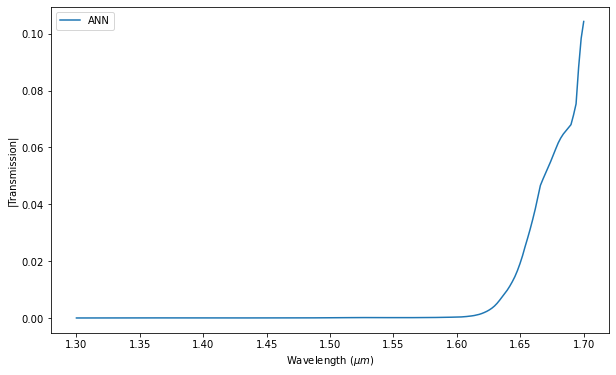

In [610]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

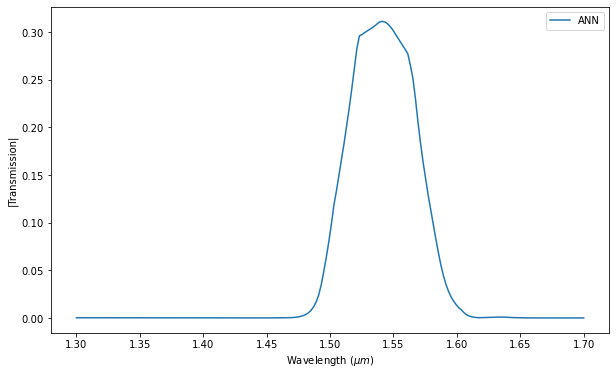

In [611]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

In [600]:
theta = (10)
pitch = (1.5*10**(-6))
duty_cycle = (0.45)
fill_factor = (0.55)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, GratingCouplerNet_old(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, GratingCouplerNet_old(x).detach().numpy())

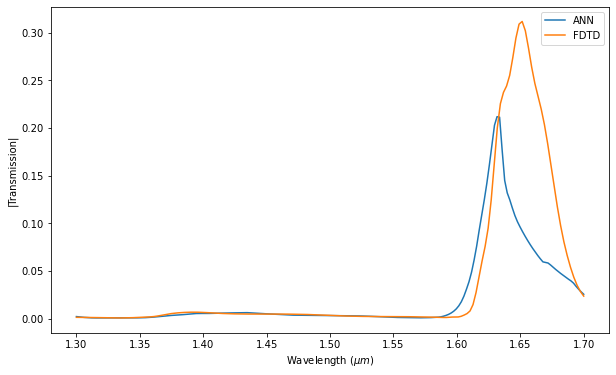

In [601]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.plot(np.flip(test_TM['X'])/10**(-6), np.abs(np.flip(test_TM['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

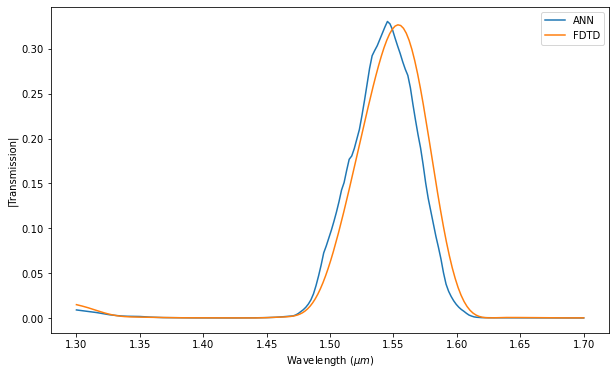

In [602]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(test_TE['X'])/10**(-6), np.abs(np.flip(test_TE['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

In [573]:
theta = (8.5)
pitch = (0.886*10**(-6))
duty_cycle = (0.8)
fill_factor = (0.6)
wavelength = np.linspace(1.3*10**(-6), 1.7*10**(-6), 200)

transmission_TM = np.zeros(len(wavelength))
transmission_TE = np.zeros(len(wavelength))

for i in range(len(wavelength)):
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 1)
    transmission_TM[i] = np.power(10, GratingCouplerNet(x).detach().numpy())
    
    x = get_normalized_data_point(theta, pitch, duty_cycle, fill_factor, wavelength[i], 0)
    transmission_TE[i] = np.power(10, GratingCouplerNet(x).detach().numpy())

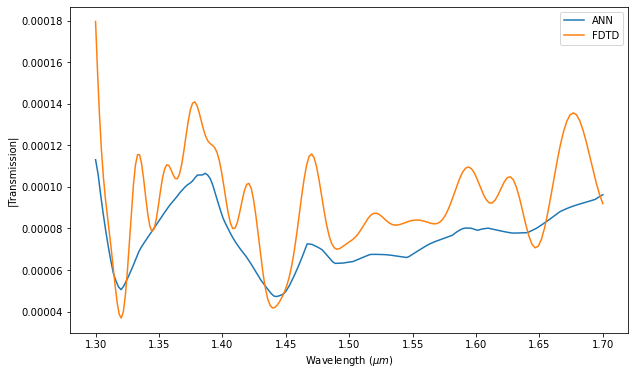

In [574]:
plt.plot(wavelength/10**(-6), transmission_TM, label='ANN')
plt.plot(np.flip(test_TM2['X'])/10**(-6), np.abs(np.flip(test_TM2['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()

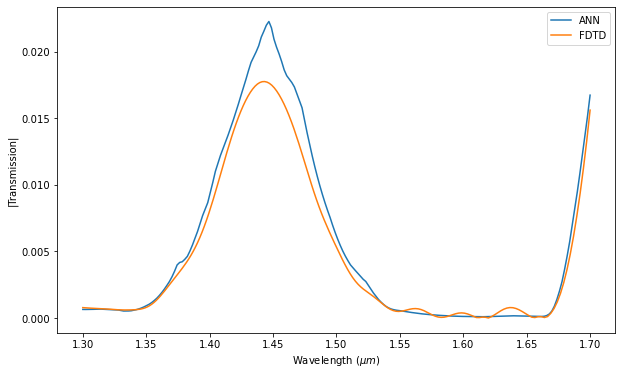

In [575]:
plt.plot(wavelength/10**(-6), transmission_TE, label='ANN')
plt.plot(np.flip(test_TE2['X'])/10**(-6), np.abs(np.flip(test_TE2['Y'])), label='FDTD')
plt.xlabel('Wavelength ' + r'$(\mu m)$')
plt.ylabel('|Transmission|')
plt.legend()